# Generating long-range entanglement with measurements
*Usage estimate: 3 minutes on IBM Torino (NOTE: This is an estimate only. Your runtime may vary.)*

## Background
This tutorial demonstrates how to realize a Nishimori phase transition on an IBM quantum processor. This experiment was originally described in [*Realizing the Nishimori transition across the error threshold for constant-depth quantum circuits*](https://arxiv.org/abs/2309.02863).

The Nishimori phase transition refers to the transition between short- and long-range ordered phases in the random-bond Ising model. On a quantum computer, the long-range ordered phase manifests as a state in which qubits are entangled across the entire device. This highly entangled state is prepared using the *generation of entanglement by measurement* (GEM) protocol. By utilizing mid-circuit measurements, the GEM protocol is able to entangle qubits across the entire device using circuits of only constant depth. This tutorial uses the implementation of the GEM protocol from the [GEM Suite](https://github.com/qiskit-community/gem-suite) software package.

## Requirements
Before starting this tutorial, be sure you have the following installed:

- Qiskit SDK v1.0 or later, with visualization support ( `pip install 'qiskit[visualization]'` )
- Qiskit Runtime 0.22 or later ( `pip install qiskit-ibm-runtime` )
- GEM Suite ( `pip install gem-suite` )

## Setup

In [2]:
import matplotlib.pyplot as plt

from collections import defaultdict

from qiskit_ibm_runtime import QiskitRuntimeService

from qiskit.transpiler import generate_preset_pass_manager

from gem_suite import PlaquetteLattice
from gem_suite.experiments import GemExperiment

## Step 1: Map classical inputs to a quantum problem

The GEM protocol works on a quantum processor with qubit connectivity described by a lattice. Today's IBM quantum processors use the [heavy hex lattice](https://www.ibm.com/quantum/blog/heavy-hex-lattice). The qubits of the processor are grouped into *plaquettes* based on which unit cell of the lattice they occupy. Because a qubit might occur in more than one unit cell, the plaquettes are not disjoint. On the heavy hex lattice, a plaquette contains 12 qubits. The plaquettes themselves also form lattice, where two plaquettes are connected if they share any qubits. On the heavy hex lattice, neighboring plaquettes share 3 qubits.

In the GEM Suite software package, the fundamental class for implementing the GEM protocol is `PlaquetteLattice`, which represents the lattice of plaquettes (which is distinct from the heavy hex lattice). A `PlaquetteLattice` can be initialized from a qubit coupling map. Currently, only heavy hex coupling maps are supported.

The following code cell initializes a plaquette lattice from the coupling map of a IBM Quantum processor. The plaquette lattice does not always encompass the entire hardware. For example, `ibm_torino` has 133 total qubits, but the largest plaquette lattice that fits on the device uses only 125 of them, and comprises a total of 18 plaquettes. Similar can be observed for IBM Quantum devices with different qubit counts as well.

In [6]:
# QiskitRuntimeService.save_account(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>", overwrite=True, set_as_default=True)
service = QiskitRuntimeService()
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=127
)
plaquette_lattice = PlaquetteLattice.from_coupling_map(backend.coupling_map)

print(f"Number of qubits in backend: {backend.num_qubits}")
print(
    f"Number of qubits in plaquette lattice: {len(list(plaquette_lattice.qubits()))}"
)
print(f"Number of plaquettes: {len(list(plaquette_lattice.plaquettes()))}")

Number of qubits in backend: 133
Number of qubits in plaquette lattice: 125
Number of plaquettes: 18


You can visualize the plaquette lattice by generating a diagram of its graph representation. In the diagram, the plaquettes are represented by labeled hexagons, and two plaquettes are connected by an edge if they share qubits.

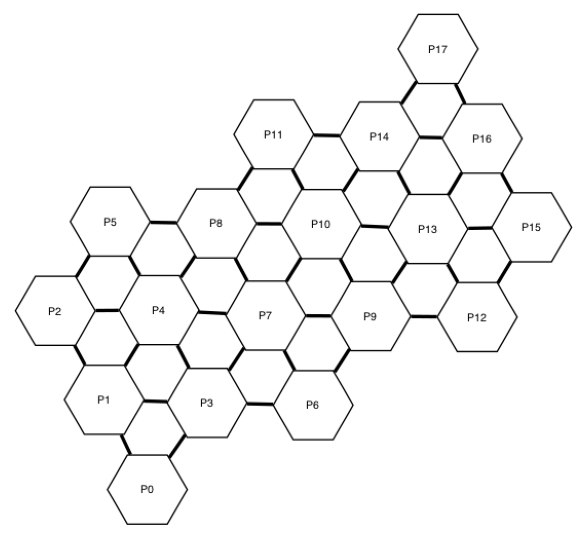

In [7]:
plaquette_lattice.draw_plaquettes()

You can retrieve information about individual plaquettes, such as the qubits they contain, using the `plaquettes` method.

In [8]:
# Get a list of the plaquettes
plaquettes = list(plaquette_lattice.plaquettes())
# Display information about plaquette 0
plaquettes[0]

PyPlaquette(index=0, qubits=[0, 1, 2, 3, 4, 15, 16, 19, 20, 21, 22, 23], neighbors=[3, 1])

You can also produce a diagram of the underlying qubits that form the plaquette lattice.

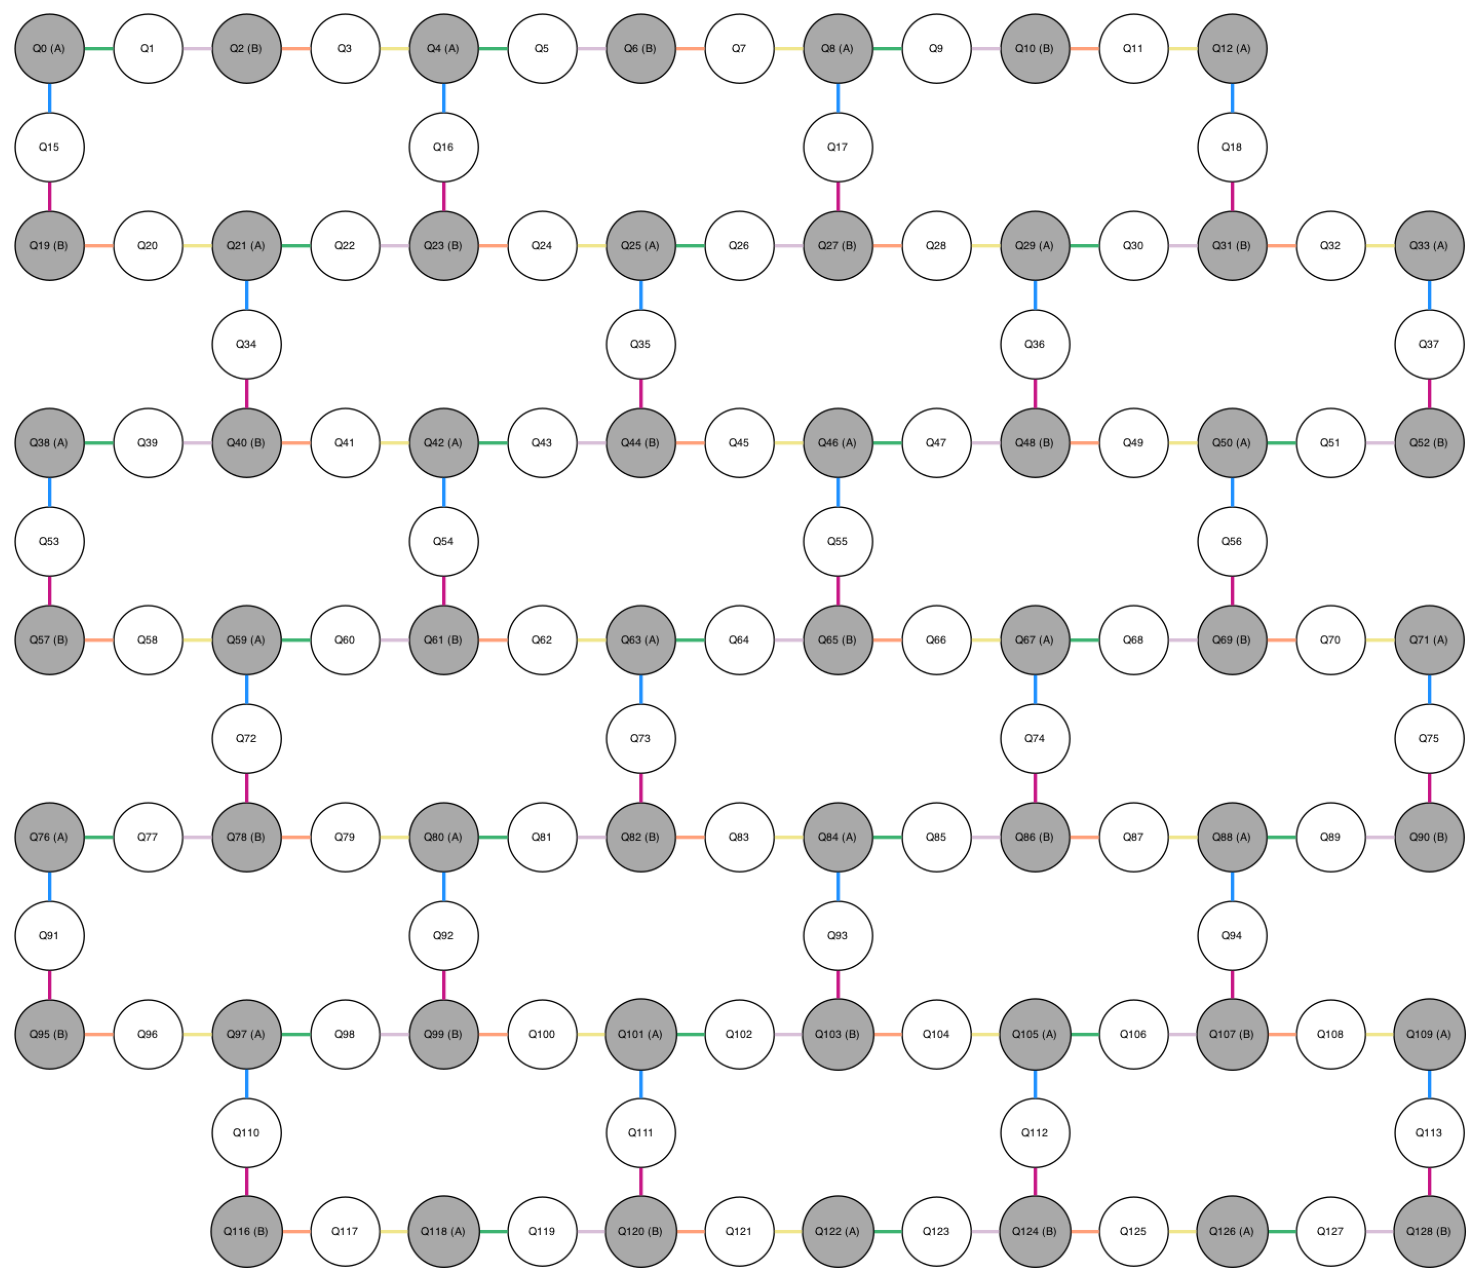

In [9]:
plaquette_lattice.draw_qubits()

In addition to the qubit labels and the edges indicating which qubits are connected, the diagram contains three additional pieces of information that are relevant to the GEM protocol:
- Each qubit is either shaded (gray) or unshaded. The shaded qubits are "site" qubits that represent the sites of the Ising model, and the unshaded qubits are "bond" qubits used to mediate interactions between the site qubits.
- Each site qubit is labeled either (A) or (B), indicating one of two roles a site qubit can play in the GEM protocol (the roles are explained later).
- Each edge is colored using one of 6 colors, thus partitioning the edges into 6 groups. This partitioning determines how two-qubit gates can be parallelized, as well as different scheduling patterns that are likely to incur different amounts of error on a noisy quantum processor. Because edges in a group are disjoint, a layer of two-qubit gates can be applied on those edges simultaneously. In fact, it is possible to partition the 6 colors into 3 groups of 2 colors such that the union of each group of 2 colors is still disjoint. Therefore, only 3 layers of two-qubit gates are needed to activate every edge. There are 12 ways to so partition the 6 colors, and each such partition yields a different 3-layer gate schedule.

Now that you have created a plaquette lattice, the next step is to initialize a `GemExperiment` object, passing both the plaquette lattice and the backend that you intend to run the experiment on. The `GemExperiment` class manages the actual implementation of the GEM protocol, including generating circuits, submitting jobs, and analyzing the data. The following code cell initializes the experiment class while restricting the plaquette lattice to only two of the plaquettes (21 qubits), reducing the size of the experiment to ensure that the noise in the hardware doesn't overwhelm the signal.

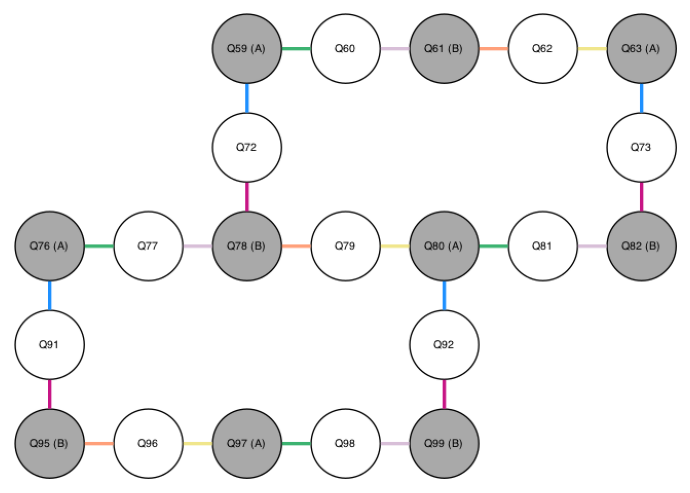

In [16]:
gem_exp = GemExperiment(plaquette_lattice.filter([9, 12]), backend=backend)

# visualize the plaquette lattice after filtering
plaquette_lattice.filter([9, 12]).draw_qubits()

A GEM protocol circuit is built using the following steps:
1. Prepare the all-$|+\rangle$ state by applying a Hadamard gate to every qubit.
2. Apply an $R_{ZZ}$ gate between every pair of connected qubits. This can be achieved using 3 layers of gates. Each $R_{ZZ}$ gate acts on a site qubit and a bond qubit. If the site qubit is labeled (B), then the angle is fixed to $\frac{\pi}{2}$. If the site qubit is labeled (A), then the angle is allowed to vary, producing different circuits. By default, the range of angles is set to 21 equally spaced points between $0$ and $\frac{\pi}{2}$, inclusive.
3. Measure each bond qubit in the Pauli $X$ basis. Since qubits are measured in the Pauli $Z$ basis, this can be accomplished by applying a Hadamard gate before measuring the qubit.

Note that the paper cited in the introduction to this tutorial uses a different convention for the $R_{ZZ}$ angle, which differs from the convention used in this tutorial by a factor of 2.

In step 3, only the bond qubits are measured. To understand what state the site qubits remain in, it is instructive to consider the case that the $R_{ZZ}$ angle applied to site qubits (A) in step 2 is equal to $\frac{\pi}{2}$. In this case, the site qubits are left in a highly entangled state similar to the GHZ state,

$$
\lvert \text{GHZ} \rangle = \lvert 00 \cdots 00 \rangle + \lvert 11 \cdots 11 \rangle.
$$

Due to the randomness in the measurement outcomes, the actual state of the site qubits might be a different state with long-range order, for example, $\lvert 00110 \rangle + \lvert 11001 \rangle$. However, the GHZ state can be recovered by applying a decoding operation based on the measurement outcomes. When the $R_{ZZ}$ angle is tuned down from $\frac{\pi}{2}$, the long-range order can still be recovered up until a critical angle, which in the absence of noise, is approximately $0.3 \pi$. Below this angle, the resulting state no longer exhibits long-range entanglement. This transition between the presence and absence of long-range order is the Nishimori phase transition.

In the description above, the site qubits were left unmeasured, and the decoding operation can be performed by applying quantum gates. In the experiment as implemented in the GEM suite, which this tutorial follows, the site qubits are in fact measured, and the decoding operation is applied in a classical post-processing step.

In the description above, the decoding operation can be performed by applying quantum gates to the site qubits to recover the quantum state. However, if the goal is to immediately measure the state, for example, for characterization purposes, then the site qubits are measured together with the bond qubits, and the decoding operation can be applied in a classical post-processing step. This is how the experiment is implemented in the GEM suite, which this tutorial follows.

In addition to depending on the $R_{ZZ}$ angle in step 2, which by default sweeps across 21 values, the GEM protocol circuit also depends on the scheduling pattern used to implement the 3 layers of $R_{ZZ}$ gates. As discussed previously, there are 12 such scheduling patterns. Therefore, the total number of circuits in the experiment is $21 \times 12 = 252$.

The circuits of the experiment can be generated using the `circuits` method of the `GemExperiment` class.

In [12]:
circuits = gem_exp.circuits()
print(f"Total number of circuits: {len(circuits)}")

Total number of circuits: 252


For the purposes of this tutorial, it is enough to consider just a single scheduling pattern. The following code cell restricts the experiment to the first scheduling pattern. As a result, the experiment only has 21 circuits, one for each $R_{ZZ}$ angle swept over.

In [13]:
# Restrict experiment to the first scheduling pattern
gem_exp.set_experiment_options(schedule_idx=0)

# There are less circuits now
circuits = gem_exp.circuits()
print(f"Total number of circuits: {len(circuits)}")

# Print the RZZ angles swept over
print(f"RZZ angles:\n{gem_exp.parameters()}")

Total number of circuits: 21
RZZ angles:
[0.         0.07853982 0.15707963 0.23561945 0.31415927 0.39269908
 0.4712389  0.54977871 0.62831853 0.70685835 0.78539816 0.86393798
 0.9424778  1.02101761 1.09955743 1.17809725 1.25663706 1.33517688
 1.41371669 1.49225651 1.57079633]


The following code cell draws a diagram of the circuit at index 5. To reduce the size of the diagram, the measurement gates at the end of the circuit are removed.

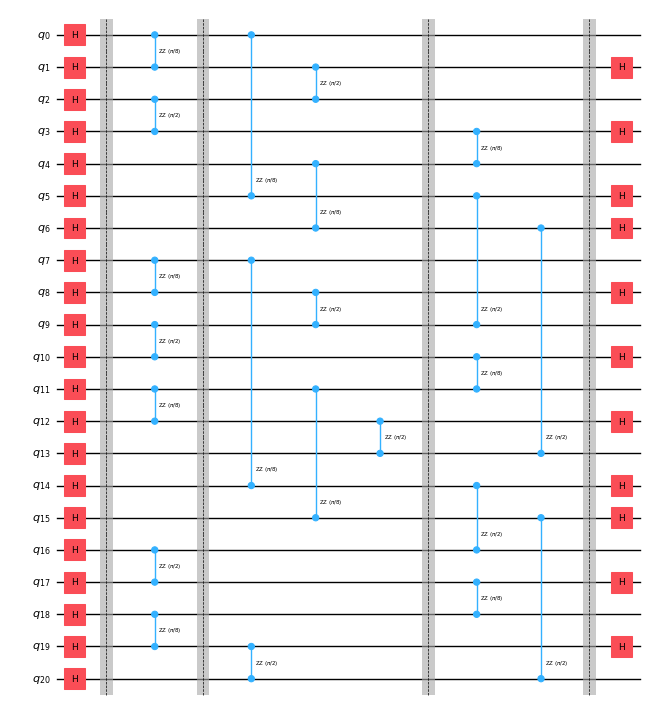

In [14]:
# Get the circuit at index 5
circuit = circuits[5]
# Remove the final measurements to ease visualization
circuit.remove_final_measurements()
# Draw the circuit
circuit.draw("mpl", fold=-1, scale=0.5)

## Step 2: Optimize problem for quantum hardware execution

Transpiling quantum circuits for execution on hardware typically involves a [number of stages](https://docs.quantum.ibm.com/guides/transpiler-stages). Typically, the stages that incur the most computational overhead are choosing the qubit layout, routing the two-qubit gates to conform to the qubit connectivity of the hardware, and optimizing the circuit to minimize its gate count and depth. In the GEM protocol, the layout and routing stages are unnecessary because the hardware connectivity is already incorporated into the design of the protocol. The circuits already have a qubit layout, and the two-qubit gates are already mapped onto native connections. Furthermore, in order to preserve the structure of the circuit as the $R_{ZZ}$ angle is varied, only very basic circuit optimization should be performed.

The `GemExperiment` class transparently transpiles circuits when executing the experiment. The layout and routing stages are already overridden by default to do nothing, and circuit optimization is performed at a level that only optimizes single-qubit gates. However, you can override or pass additional options using the `set_transpile_options` method. For the sake of visualization, the following code cell manually transpiles the circuit displayed previously, and draws the transpiled circuit.

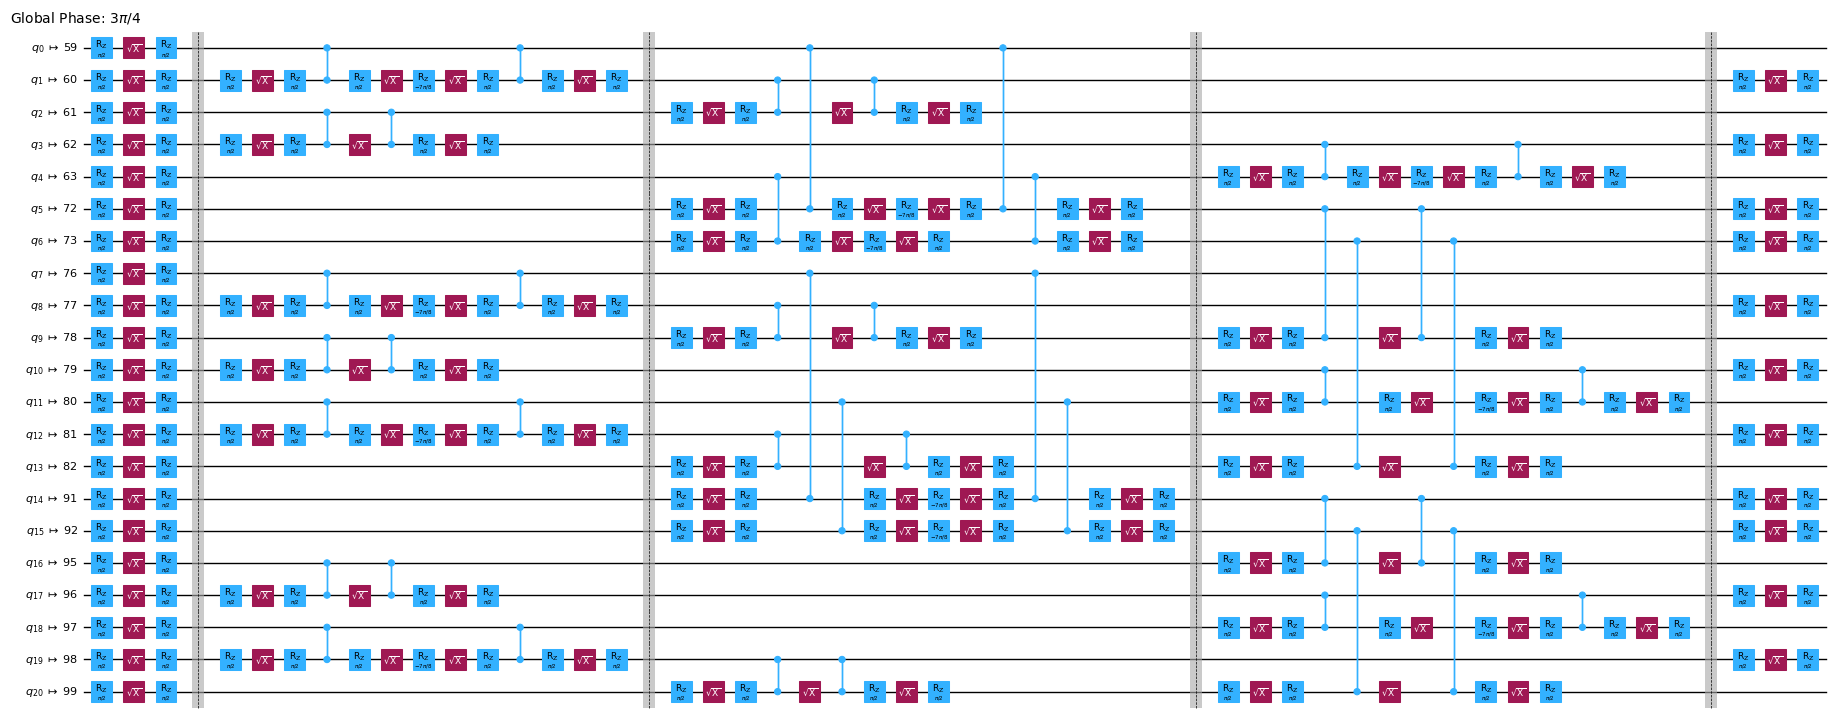

In [15]:
# Demonstrate setting transpile options
gem_exp.set_transpile_options(
    optimization_level=1  # This is the default optimization level
)
pass_manager = generate_preset_pass_manager(
    backend=backend,
    initial_layout=list(gem_exp.physical_qubits),
    **dict(gem_exp.transpile_options),
)
transpiled = pass_manager.run(circuit)
transpiled.draw("mpl", idle_wires=False, fold=-1, scale=0.5)

## Step 3: Execute using Qiskit primitives

To execute the GEM protocol circuits on the hardware, call the `run` method of the `GemExperiment` object. You can specify the number of shots you want to sample from each circuit. The `run` method returns an [ExperimentData](https://qiskit-community.github.io/qiskit-experiments/stubs/qiskit_experiments.framework.ExperimentData.html) object which you should save to a variable. Note that the `run` method only submits jobs without waiting for them to finish, so it is a non-blocking call.

In [10]:
exp_data = gem_exp.run(shots=10_000)

To wait for the results, call the `block_for_results` method of the `ExperimentData` object. This call will cause the interpreter to hang until the jobs are finished.

In [11]:
exp_data.block_for_results()

ExperimentData(GemExperiment, d0d5880a-34c1-4aab-a7b6-c4f58516bc03, job_ids=['cwg12ptmptp00082khhg'], metadata=<5 items>, figure_names=['two_point_correlation.svg', 'normalized_variance.svg', 'plaquette_ops.svg', 'bond_ops.svg'])

## Step 4: Post-process and return result in desired classical format

At an $R_{ZZ}$ angle of $\frac{\pi}{2}$, the decoded state would be the GHZ state in the absence of noise. The long-range order of the GHZ state can be visualized by plotting the magnetization of the measured bitstrings. The magnetization $M$ is defined as the sum of the single-qubit Pauli $Z$ operators,
$$
M = \sum_{j=1}^N Z_j,
$$
where $N$ is the number of site qubits. Its value for a bitstring is equal to the difference between the number of zeros and the number of ones. Measuring the GHZ state yields the all zeros state or the all ones state with equal probability, so the magnetization would be $+N$ half of the time and $-N$ the other half of the time. In the presence of errors due to noise, other values would also appear, but if the noise is not too great, the distribution would still be peaked near $+N$ and $-N$.

For the raw bitstrings before decoding, the distribution of the magnetization would be equivalent to that of uniformly random bitstrings, in the absence of noise.

The following code cell plots the magnetization of the raw bitstrings and the decoded bitstrings at the $R_{ZZ}$ angle of $\frac{\pi}{2}$.

Text(0.5, 1.0, 'Magnetization distribution with and without decoding')

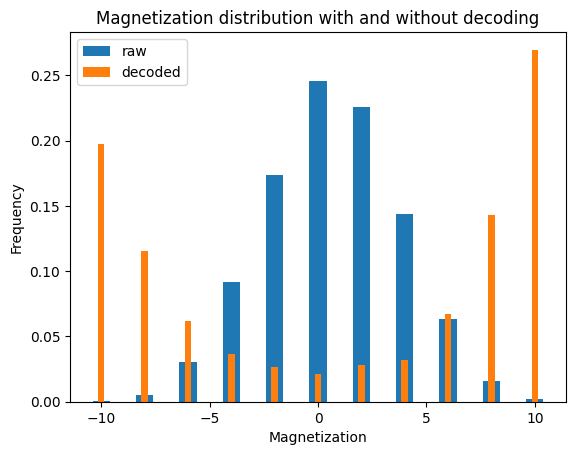

In [ ]:
def magnetization_distribution(
    counts_dict: dict[str, int],
) -> dict[str, float]:
    """Compute magnetization distribution from counts dictionary."""
    # Construct dictionary from magnetization to count
    mag_dist = defaultdict(float)
    for bitstring, count in counts_dict.items():
        mag = bitstring.count("0") - bitstring.count("1")
        mag_dist[mag] += count
    # Normalize
    shots = sum(counts_dict.values())
    for mag in mag_dist:
        mag_dist[mag] /= shots
    return mag_dist


# Get counts dictionaries with and without decoding
data = exp_data.data()
# Get the last data point, which is at the angle for the GHZ state
raw_counts = data[-1]["counts"]
# Without decoding
site_indices = [
    i for i, q in enumerate(gem_exp.plaquettes.qubits()) if q.role == "Site"
]
site_raw_counts = defaultdict(int)
for key, val in raw_counts.items():
    site_str = "".join(key[-1 - i] for i in site_indices)
    site_raw_counts[site_str] += val
# With decoding
_, site_decoded_counts = gem_exp.plaquettes.decode_outcomes(
    raw_counts, return_counts=True
)

# Compute magnetization distribution
raw_magnetization = magnetization_distribution(site_raw_counts)
decoded_magnetization = magnetization_distribution(site_decoded_counts)

# Plot
plt.bar(*zip(*raw_magnetization.items()), label="raw")
plt.bar(*zip(*decoded_magnetization.items()), label="decoded", width=0.3)
plt.legend()
plt.xlabel("Magnetization")
plt.ylabel("Frequency")
plt.title("Magnetization distribution with and without decoding")

To more rigorously characterize the long-range order, you can examine the average two-point correlation $f$, defined as
$$
f = \frac{1}{N^2} \left(\langle M^2 \rangle - \langle M \rangle ^2\right).
$$
A higher value indicates a greater degree of entanglement. The `GemExperiment` class automatically computes this value for the decoded bitstrings as part of processing the experimental data. It stores a figure that is accessible via the `figure` method of the experiment data class. In this case, the name of the figure is `two_point_correlation`.

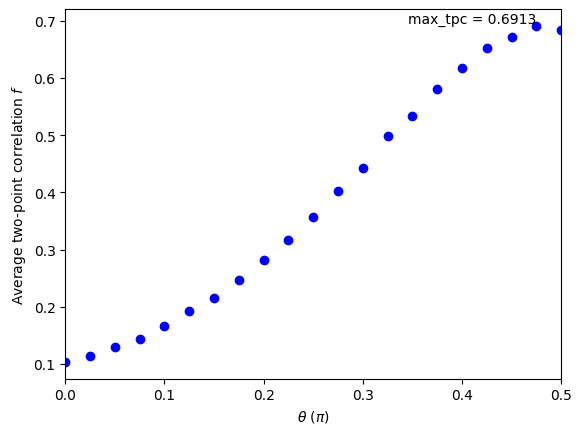

In [13]:
exp_data.figure("two_point_correlation")

To determine the critical point of the Nishimori phase transition, you can look at the normalized variance of $M^2 / N$, defined as
$$
g = \frac{1}{N^3} \left(\langle M^4 \rangle - \langle M^2 \rangle^2\right),
$$
which quantifies the amount of fluctuation in the squared magnetization. This value is maximized at the critical point of the Nishimori phase transition. In the absence of noise, the critical point occurs at approximately $0.3 \pi$. In the presence of noise, the critical point is shifted higher, but the phase transition is still observed as long as the critical point occurs below $0.5 \pi$.

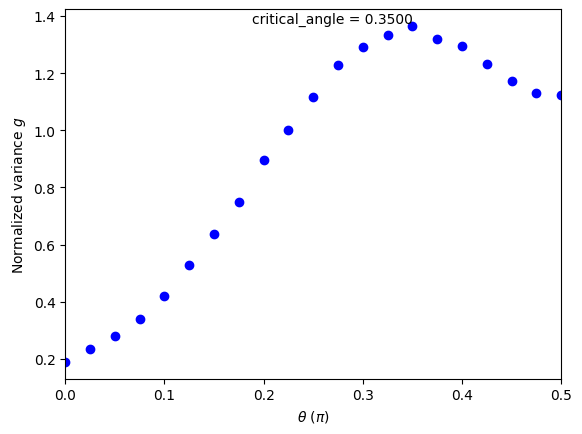

In [14]:
exp_data.figure("normalized_variance")

## Scale up the experiment

The following code cells run the experiment for 6 plaquettes (49 qubits) and the full 12 plaquettes (125 qubits) and plot the normalized variance. As the experiment is scaled to larger sizes, the greater amount of noise shifts the critical point rightwards.

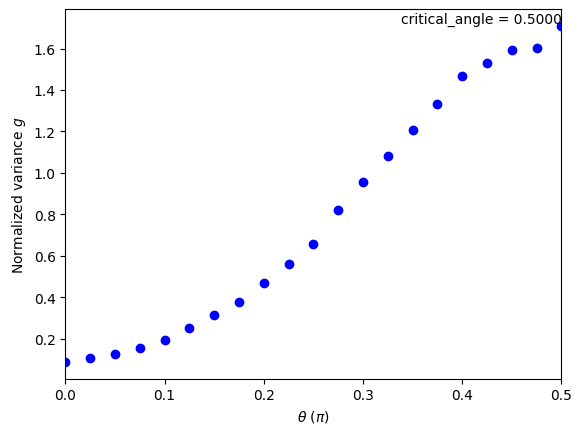

In [15]:
gem_exp = GemExperiment(
    plaquette_lattice.filter(range(3, 9)), backend=backend
)
gem_exp.set_experiment_options(schedule_idx=0)
exp_data = gem_exp.run(shots=10_000)
exp_data.block_for_results()
exp_data.figure("normalized_variance")

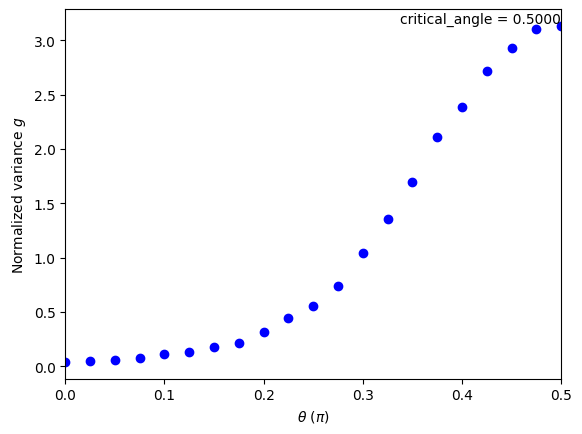

In [16]:
gem_exp = GemExperiment(plaquette_lattice, backend=backend)
gem_exp.set_experiment_options(schedule_idx=0)
exp_data = gem_exp.run(shots=10_000)
exp_data.block_for_results()
exp_data.figure("normalized_variance")

## Conclusion

In this tutorial, you realized a Nishimori phase transition on a quantum processor using the GEM protocol. The metrics that you examined during post-processing, in particular the two-point correlation and the normalized variance, serve as benchmarks of the device's ability to generate long-range entangled states. These benchmarks extend the utility of the GEM protocol beyond probing interesting physics. As part of the protocol, you entangled qubits across the entire device using circuits of only constant depth. This feat is only possible due to the protocol's use of mid-circuit measurements. In this experiment, the entangled state was immediately measured, but an interesting avenue to explore would be to continue using the state in additional quantum processing!

## Tutorial survey

Please take one minute to provide feedback on this tutorial. Your insights will help us improve our content offerings and user experience.

[Link to survey](https://your.feedback.ibm.com/jfe/form/SV_bsCKQkgzuQUQ7ky)

© IBM Corp. 2024